In [2]:
# pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# pip install --upgrade pip
# pip install tensorflow

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [3]:
path_to_POSCAR_MBT = 'DFT_CONTCARs_MBT/'

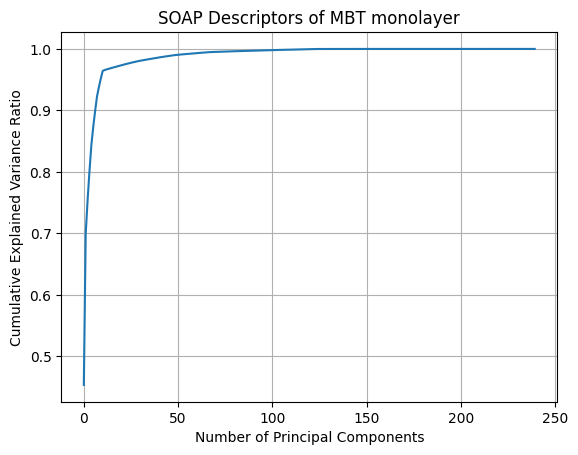

In [4]:
## Read POSCARs file and extract the information
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format = 'vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

poscar_info_list, atomic_species_list, unique_atomic_species_list = read_POSCAR(path_to_POSCAR_MBT)

## Extract the SOAP descriptors
def get_SOAP_descriptor(poscar_info_list, r_cut, n_max, l_max):
    
    poscar_info_list,_,unique_atomic_species_list = read_POSCAR(path_to_POSCAR_MBT)
    soap = SOAP(species = unique_atomic_species_list,
               r_cut = r_cut,
               n_max = n_max,
               l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average='inner',  # default: 'off'
                periodic=True,  # default: False
                sparse=False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

## call the SOAP function
soap_desc = get_SOAP_descriptor(poscar_info_list, 9.0, 6, 5)

## Plot the PCA variance to determine the number of principal components
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()
    
plot_PCA_variance(soap_desc,240)

In [5]:
## Apply PCA to the optimal components
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components=optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

optimized_pca = perform_pca(soap_desc,100)

## Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca)
latent_size = 32
input_dim = X.shape[1]


## encoder model
encoder_input = keras.Input(shape=(input_dim,))
# encoder = keras.layers.Dense(128, activation = 'selu')(encoder_input)
# encoder = keras.layers.Dense(96, activation = 'selu')(encoder)
encoder = keras.layers.Dropout(0.2)(encoder_input)
encoder_output = keras.layers.Dense(32, activation = 'selu', kernel_regularizer=tf.keras.regularizers.L2(0.0001))(encoder)

## decoder model
# decoder = keras.layers.Dense(96, activation = 'selu')(encoder_output)
# decoder = keras.layers.Dense(128, activation = 'selu')(decoder)
decoder = keras.layers.Dropout(0.2)(encoder_output)
decoder_output = keras.layers.Dense(input_dim, activation = 'linear')(encoder_output)

## autoencoder
autoencoder = keras.models.Model(inputs = encoder_input, outputs = decoder_output)
autoencoder.compile(optimizer='adam', loss = 'mae',)

hist_autoencoder = autoencoder.fit(X, X, epochs = 100, batch_size = 32, validation_split = 0.2)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9809 - val_loss: 0.8479
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9198 - val_loss: 0.8326
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8733 - val_loss: 0.8173
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8783 - val_loss: 0.8027
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8367 - val_loss: 0.7886
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8277 - val_loss: 0.7750
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7881 - val_loss: 0.7623
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7696 - val_loss: 0.7500
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7310 - val_loss: 0.7377
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7169 - val_loss: 0.7257
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7090 - val_loss: 0.7144
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6797 - val_loss: 0.7038


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4065 - val_loss: 0.5196
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4083 - val_loss: 0.5192
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4069 - val_loss: 0.5191
Epoch 73/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4029 - val_loss: 0.5191
Epoch 74/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4018 - val_loss: 0.5189
Epoch 75/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4044 - val_loss: 0.5186
Epoch 76/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4004 - val_loss: 0.5187
Epoch 77/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4007 - val_loss: 0.5187
Epoch 78/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4004 - val_loss: 0.5183
Epoch 79/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4011 - val_loss: 0.5179
Epoch 80/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3926 - val_loss: 0.5174
Epoch 81/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3963 - val_loss: 0.5168
Ep

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


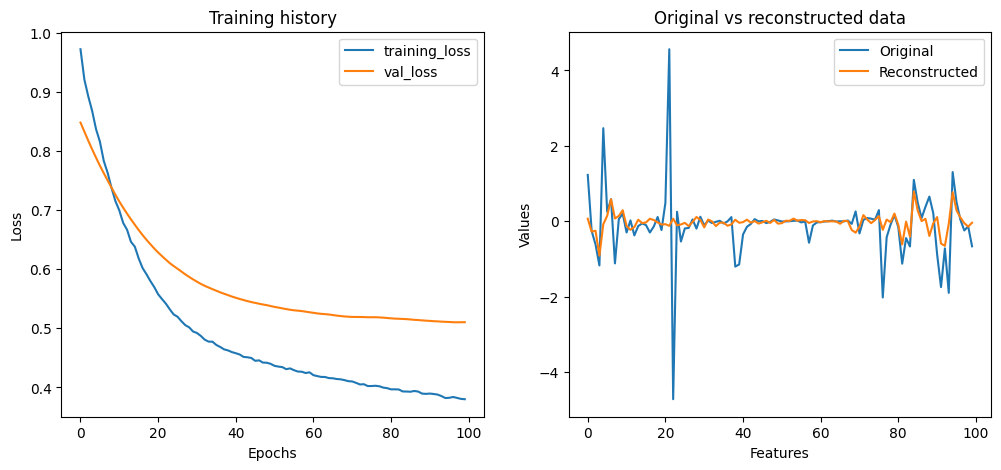

In [6]:
reconstructed_X = autoencoder.predict(X)
encoder_model = keras.models.Model(inputs = encoder_input, outputs = encoder_output)
compressed_X = encoder_model.predict(X)
compressed_X.shape

fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(hist_autoencoder.history['loss'], label='training_loss')
ax[0].plot(hist_autoencoder.history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training history')
ax[0].legend()

ax[1].plot(X[0], label='Original')
ax[1].plot(reconstructed_X[0], label='Reconstructed')
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Values')
ax[1].set_title('Original vs reconstructed data')
ax[1].legend()
plt.show()

Epoch 1/500


C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7721 - val_loss: 1.8500
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6458 - val_loss: 1.7730
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6047 - val_loss: 1.7026
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5295 - val_loss: 1.6410
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3983 - val_loss: 1.5867
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3907 - val_loss: 1.5342
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3407 - val_loss: 1.4839
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2994 - val_loss: 1.4380
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2844 - val_loss: 1.3922
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2110 - val_loss: 1.3478
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1998 - val_loss: 1.3028
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1153 - val_l

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3161 - val_loss: 0.6849
Epoch 138/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2565 - val_loss: 0.6858
Epoch 139/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3073 - val_loss: 0.6854
Epoch 140/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2771 - val_loss: 0.6844
Epoch 141/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2739 - val_loss: 0.6876
Epoch 142/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2739 - val_loss: 0.6860
Epoch 143/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2763 - val_loss: 0.6833
Epoch 144/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3003 - val_loss: 0.6844
Epoch 145/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2545 - val_loss: 0.6866
Epoch 146/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2861 - val_loss: 0.6866
Epoch 147/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2670 - val_loss: 0.6901
Epoch 148/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2024 - val_loss: 0.6778
Epoch 272/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2069 - val_loss: 0.6755
Epoch 273/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2044 - val_loss: 0.6797
Epoch 274/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2144 - val_loss: 0.6826
Epoch 275/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2189 - val_loss: 0.6771
Epoch 276/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2122 - val_loss: 0.6729
Epoch 277/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2026 - val_loss: 0.6765
Epoch 278/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2188 - val_loss: 0.6756
Epoch 279/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2075 - val_loss: 0.6645
Epoch 280/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2167 - val_loss: 0.6853
Epoch 281/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1882 - val_loss: 0.6724
Epoch 282/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1766 - val_loss: 0.7011
Epoch 406/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1659 - val_loss: 0.6946
Epoch 407/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1705 - val_loss: 0.6939
Epoch 408/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1477 - val_loss: 0.7030
Epoch 409/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1680 - val_loss: 0.6957
Epoch 410/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1660 - val_loss: 0.6998
Epoch 411/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1614 - val_loss: 0.6947
Epoch 412/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1863 - val_loss: 0.6935
Epoch 413/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1489 - val_loss: 0.7025
Epoch 414/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1502 - val_loss: 0.6934
Epoch 415/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1771 - val_loss: 0.6977
Epoch 416/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

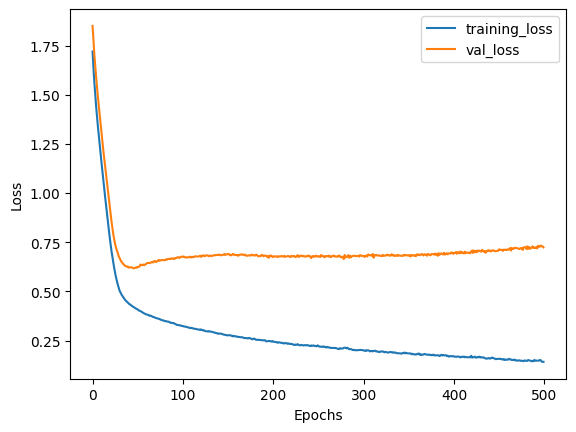

In [189]:
## Load the data for FFNN
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')
y = monolayer_MBT_DFT_data[['Ef_per_cell','Mu_per_cell','Eg']]

## FFNN
ffnn_MBT = keras.models.Sequential([
    keras.layers.Dense(16, activation = 'selu', input_dim = latent_size),
    keras.layers.Dense(8, activation = 'selu'),
#     keras.layers.Dense(8, activation = 'selu'),
    keras.layers.Dense(3, activation = 'linear')
])

X_train, X_test, y_train, y_test = train_test_split(compressed_X, y, test_size = 0.2, random_state = 1)

ffnn_MBT.compile(optimizer = 'adam', loss = 'mae')
hist_ffnn_MBT = ffnn_MBT.fit(X_train, y_train, epochs = 500, batch_size = 16, validation_split = 0.2)

plt.plot(hist_ffnn_MBT.history['loss'], label='training_loss')
plt.plot(hist_ffnn_MBT.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


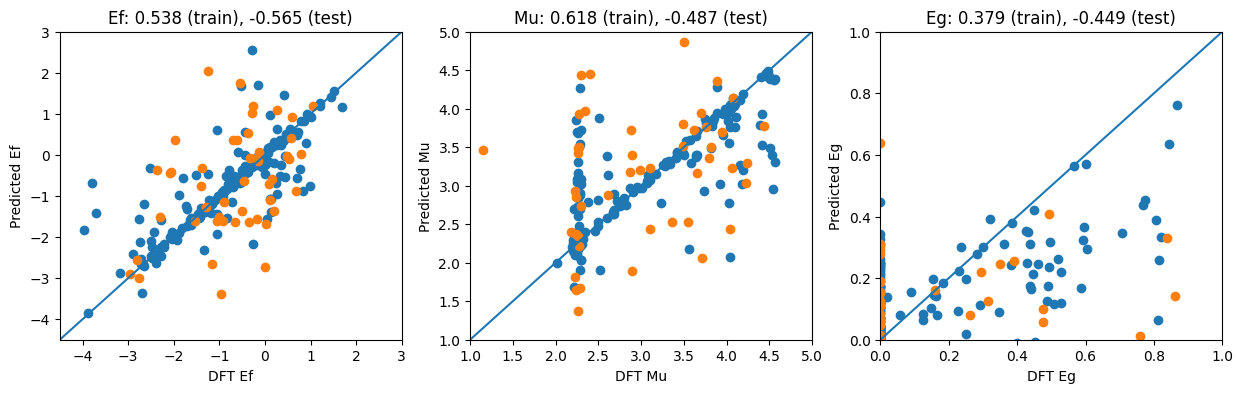

In [190]:
pred_train = ffnn_MBT.predict(X_train)
pred_test = ffnn_MBT.predict(X_test)

fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
ax1.scatter(y_train['Ef_per_cell'], pred_train[:,0])
ax1.scatter(y_test['Ef_per_cell'], pred_test[:,0])
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train['Mu_per_cell'], pred_train[:,1])
ax2.scatter(y_test['Mu_per_cell'], pred_test[:,1])
ax2.plot([0, 5], [0, 5])

ax3.scatter(y_train['Eg'], pred_train[:,2])
ax3.scatter(y_test['Eg'], pred_test[:,2])
ax3.plot([0, 1], [0, 1])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]),metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]),metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1])))
ax3.set_title('Eg: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Eg'], pred_train[:,2]),metrics.r2_score(y_test['Eg'], pred_test[:,2])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax3.set_xlabel('DFT Eg')
ax3.set_ylabel('Predicted Eg')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

plt.show()

In [142]:
print('Properties \t', 'R2(Train) \t','R2(Test) \t','MAE(Train) \t','MAE(Test)')
print('Ef \t\t {:.3} \t\t {:.3} \t {:.3} \t\t {:.3}'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]), metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0]), metrics.mean_absolute_error(y_train['Ef_per_cell'], pred_train[:,0]), metrics.mean_absolute_error(y_test['Ef_per_cell'], pred_test[:,0])))
print('Mu \t\t {:.3} \t\t {:.3} \t {:.3} \t\t {:.3}'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]), metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1]), metrics.mean_absolute_error(y_train['Mu_per_cell'], pred_train[:,1]), metrics.mean_absolute_error(y_test['Mu_per_cell'], pred_test[:,1])))
print('Eg \t\t {:.3} \t\t {:.3} \t {:.3} \t\t {:.3}'.format(metrics.r2_score(y_train['Eg'], pred_train[:,2]), metrics.r2_score(y_test['Eg'], pred_test[:,2]), metrics.mean_absolute_error(y_train['Eg'], pred_train[:,2]), metrics.mean_absolute_error(y_test['Eg'], pred_test[:,2])))

Properties 	 R2(Train) 	 R2(Test) 	 MAE(Train) 	 MAE(Test)
Ef 		 0.695 		 -0.0102 	 0.321 		 0.805
Mu 		 0.593 		 -0.847 	 0.266 		 0.834
Eg 		 0.438 		 -0.333 	 0.115 		 0.221


In [33]:
# ## plot of R2 score vs unlabelled data
# # !pip install openpyxl

# unlabelled_data_R2 = pd.read_excel('unlabelled_data_r2_score.xlsx')

# fig,ax = plt.subplots(1,2,figsize = (12,5))
# ax[0].plot(unlabelled_data_R2['unlabelled_data'], unlabelled_data_R2['Ef_train_R2'], label = 'Ef')
# ax[0].plot(unlabelled_data_R2['unlabelled_data'], unlabelled_data_R2['Mu_train_R2'], label = 'Mu')
# ax[0].plot(unlabelled_data_R2['unlabelled_data'], unlabelled_data_R2['Eg_train_R2'], label = 'Eg')
# ax[0].set_ylabel('R2 score')
# ax[0].set_xlabel('Number of unlabelled data')
# ax[0].set_ylim([0,1])
# ax[0].legend()

# ax[1].plot(unlabelled_data_R2['unlabelled_data'], unlabelled_data_R2['Ef_test_R2'], label = 'Ef')
# ax[1].plot(unlabelled_data_R2['unlabelled_data'], unlabelled_data_R2['Mu_test_R2'], label = 'Mu')
# ax[1].plot(unlabelled_data_R2['unlabelled_data'], unlabelled_data_R2['Eg_test_R2'], label = 'Eg')
# ax[1].set_ylabel('R2 score')
# ax[1].set_xlabel('Number of unlabelled data')
# ax[1].legend()

# plt.show()